In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import shift
from darts import TimeSeries
from darts.models import XGBModel, LinearRegressionModel, CatBoostModel
from tqdm import tqdm
import pdb

In [11]:
data = pd.read_csv(
    './deaths.csv'
)[['ahead', 'forecaster', 'geo_value', 'target_end_date', 'forecast_0.1', 'forecast_0.5', 'forecast_0.9', 'actual']]
data_cases = pd.read_csv(
    './cases.csv'
)[['ahead', 'forecaster', 'geo_value', 'target_end_date', 'forecast_0.1', 'forecast_0.5', 'forecast_0.9', 'actual']]
data_cases = data_cases.rename(columns={'actual' : 'cases_actual', 'forecast_0.1' : 'cases_forecast_0.1', 'forecast_0.5' : 'cases_forecast_0.5', 'forecast_0.9': 'cases_forecast_0.9'})
data = data.merge(data_cases, on=['ahead', 'forecaster', 'geo_value', 'target_end_date'])
populations = pd.read_csv('./state_populations.csv')
populations = { populations.State[j] : populations.Population[j] for j in range(len(populations))}
weeks_ahead = 4
data = data[(data.ahead == weeks_ahead) & (data.forecaster == 'COVIDhub-4_week_ensemble') & (data.geo_value != 'us') & (data.geo_value != 'mp') & (data.geo_value != 'pr') & (data.geo_value != 'vi') & (data.geo_value != 'as') & (data.geo_value != 'gu')].reset_index(drop=True).drop(['ahead', 'forecaster'], axis=1).dropna().sort_values('target_end_date')
data.target_end_date = pd.to_datetime(data.target_end_date)
states = np.unique(data.geo_value)
dates = np.unique(data.target_end_date); dates.sort()
data['population'] = [int(populations[st]) for st in data.geo_value]
data['score_upper'] = (data['actual'] - data['forecast_0.9'])/data['population']
data['score_lower'] = (data['forecast_0.1'] - data['actual'])/data['population']
data['cases_score_upper'] = (data['cases_actual'] - data['cases_forecast_0.9'])/data['population']
data['cases_score_lower'] = (data['cases_forecast_0.1'] - data['cases_actual'])/data['population']
print(len(data))
data.head()

6885


,geo_value,target_end_date,forecast_0.1,forecast_0.5,forecast_0.9,actual,cases_forecast_0.1,cases_forecast_0.5,cases_forecast_0.9,cases_actual,population,score_upper,score_lower,cases_score_upper,cases_score_lower
0,hi,2020-08-15,0.0,2.0,17.0,9.0,60.0,198.0,524.0,1479.0,1455271,-0.000005,-0.000006,0.000656,-0.000975
28,tx,2020-08-15,748.0,1335.0,1814.0,1222.0,39176.0,64211.0,105096.0,77337.0,29145505,-0.000020,-0.000016,-0.000952,-0.001309
29,oh,2020-08-15,72.0,133.0,261.0,166.0,5423.0,9699.0,15641.0,7705.0,11799448,-0.000008,-0.000008,-0.000673,-0.000193
30,la,2020-08-15,89.0,167.0,341.0,223.0,10144.0,20595.0,37997.0,7991.0,4657757,-0.000025,-0.000029,-0.006442,0.000462
31,nj,2020-08-15,64.0,131.0,221.0,41.0,193.0,1047.0,4040.0,3299.0,9288994,-0.000019,0.000002,-0.000080,-0.000334


In [28]:
scorecasts_upper_xgb = np.zeros((len(data),))
scorecasts_upper_linreg = np.zeros((len(data),))
train_length=10 # 20 works well for XGB with no quantile
for state in tqdm(states):
    geo_idx = data.geo_value == state
    ts_scores_upper = TimeSeries.from_dataframe(data[geo_idx], time_col='target_end_date', value_cols='score_upper')
    ts_covariates = TimeSeries.from_group_dataframe(data, group_cols='geo_value', time_col='target_end_date', value_cols=['score_upper', 'cases_score_upper','actual'])
    #model_upper_xgb = XGBModel(lags=[-3, -4], lags_past_covariates=[-3], likelihood='quantile', quantiles=[0.1, 0.5, 0.90])
    model_upper_linreg = LinearRegressionModel(lags=[-3], lags_past_covariates=[-3], likelihood='quantile', quantiles=[0.1, 0.5, 0.90])
    # Perform the backtesting
    #backtests_xgb = model_upper_xgb.historical_forecasts(ts_scores_upper, past_covariates=ts_covariates, train_length=train_length, num_samples=10).quantile(0.9)
    #scorecasts_upper_xgb[geo_idx.to_numpy().squeeze()] = np.concatenate([np.zeros((geo_idx.sum() - len(backtests_xgb),)), backtests_xgb.values().squeeze()], axis=0)
    backtests_linreg = model_upper_linreg.historical_forecasts(ts_scores_upper, past_covariates=ts_covariates, train_length=train_length, num_samples=10).quantile(0.9)
    scorecasts_upper_linreg[geo_idx.to_numpy().squeeze()] = np.concatenate([np.zeros((geo_idx.sum() - len(backtests_linreg),)), backtests_linreg.values().squeeze()], axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [01:11<00:00,  1.40s/it]


In [15]:
scorecasts_lower_xgb = np.zeros((len(data),))
scorecasts_lower_linreg = np.zeros((len(data),))
train_length=10 # 20 works well for XGB with no quantile
for state in tqdm(states):
    geo_idx = data.geo_value == state
    ts_scores_lower = TimeSeries.from_dataframe(data[geo_idx], time_col='target_end_date', value_cols='score_lower')
    ts_covariates = TimeSeries.from_group_dataframe(data, group_cols='geo_value', time_col='target_end_date', value_cols=['score_lower', 'cases_score_lower','actual'])
    model_lower_linreg = LinearRegressionModel(lags=[-3, -4], lags_past_covariates=[-3], likelihood='quantile', quantiles=[0.1, 0.5, 0.90])
    # Perform the backtesting
    backtests_linreg = model_lower_linreg.historical_forecasts(ts_scores_lower, past_covariates=ts_covariates, train_length=train_length, num_samples=10).quantile(0.9)
    scorecasts_lower_linreg[geo_idx.to_numpy().squeeze()] = np.concatenate([np.zeros((geo_idx.sum() - len(backtests_linreg),)), backtests_linreg.values().squeeze()], axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [01:11<00:00,  1.40s/it]


In [29]:
def enforce_min_size(forecasts_lower, forecasts_upper, population, scorecasts_lower, scorecasts_upper, minsize):
    adjusted_lower = forecasts_lower - (scorecasts_lower * population)
    adjusted_higher = forecasts_upper + (scorecasts_upper * population)
    inflation_factor = np.maximum(minsize - (adjusted_higher - adjusted_lower), 0)/population
    return scorecasts_lower - inflation_factor/2, scorecasts_upper + inflation_factor/2

In [30]:
data['scorecast_lower'], data['scorecast_upper'] = enforce_min_size(data['forecast_0.1'].to_numpy(),data['forecast_0.9'].to_numpy(), data['population'].to_numpy(), scorecasts_lower_linreg, scorecasts_upper_linreg, 0)

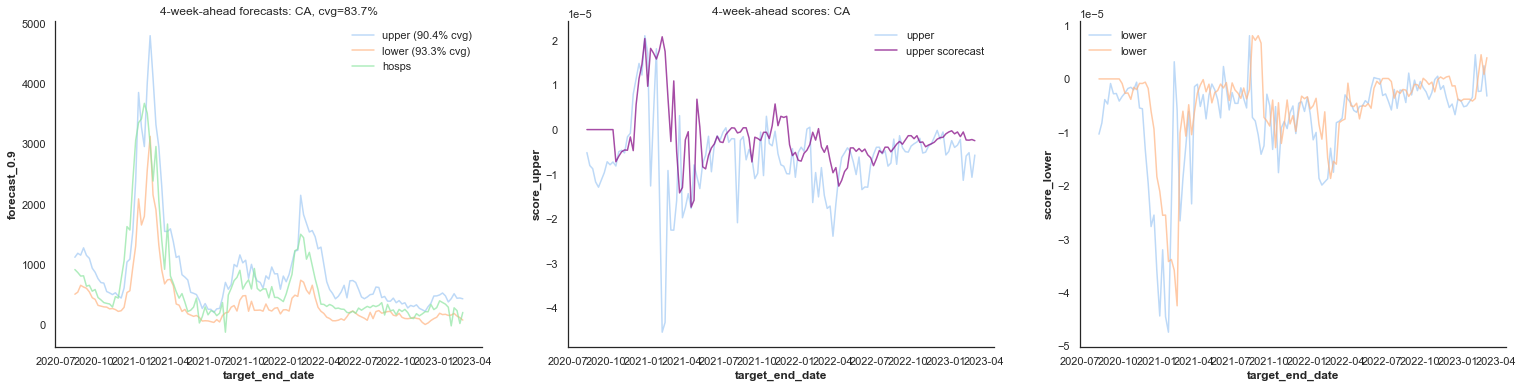

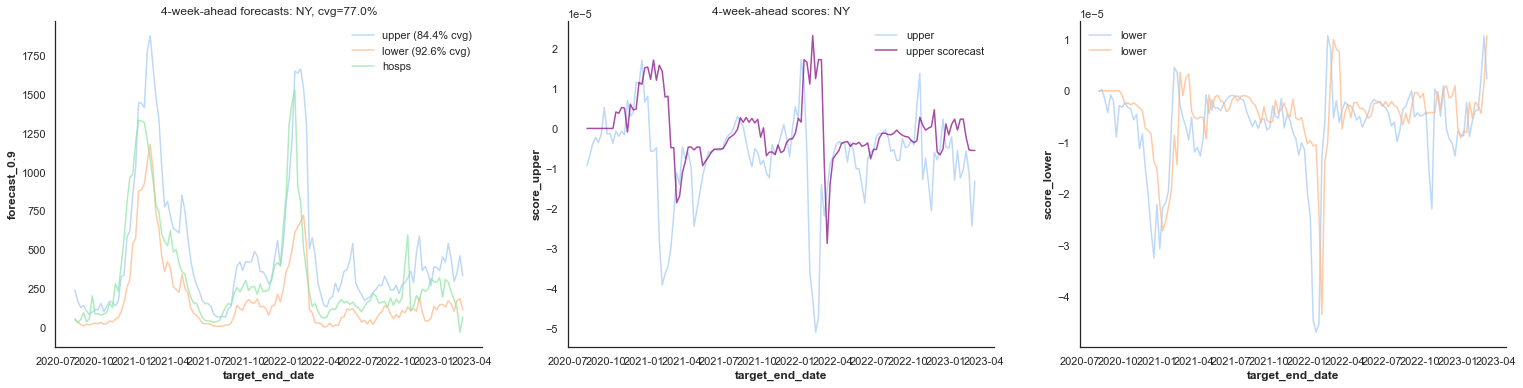

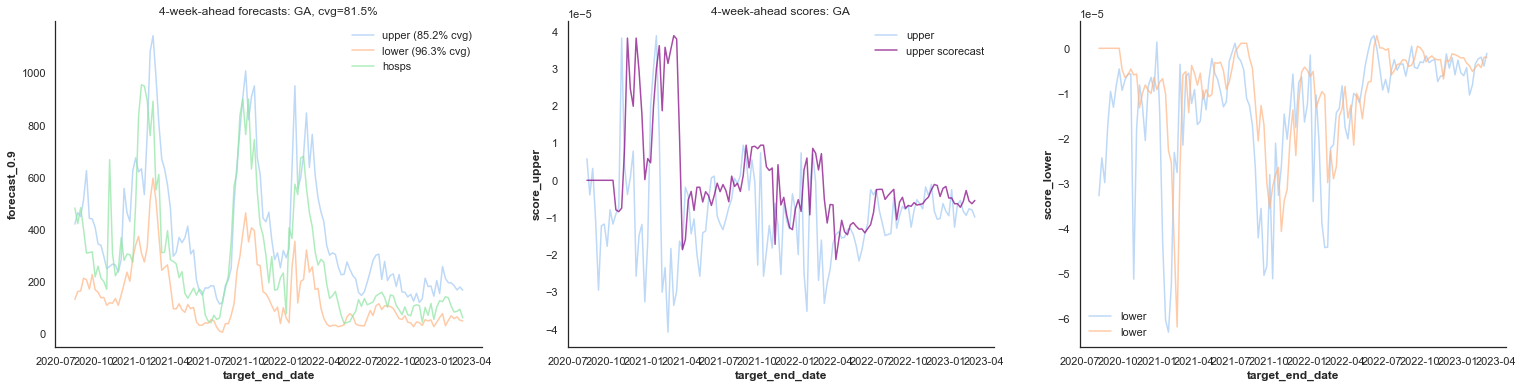

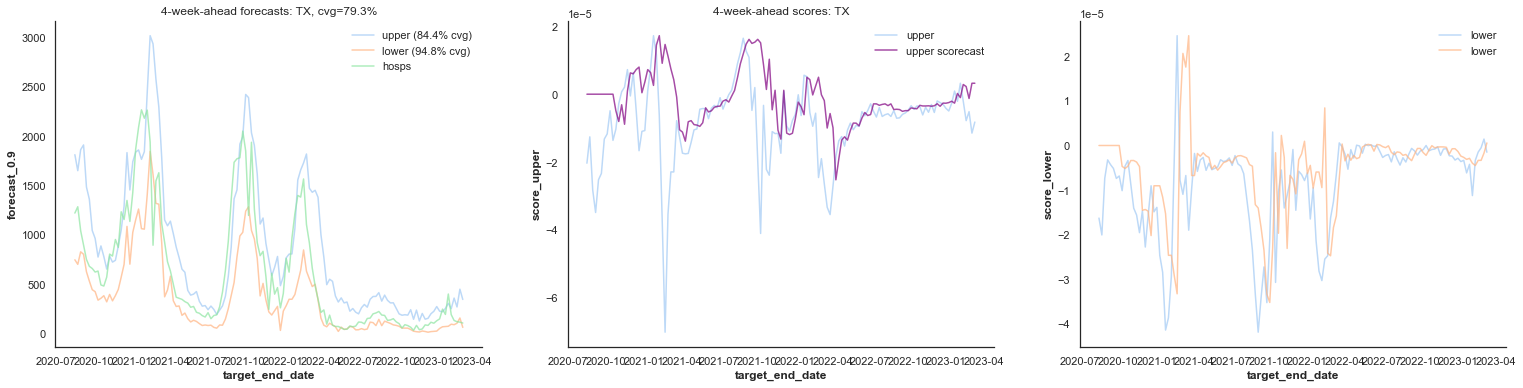

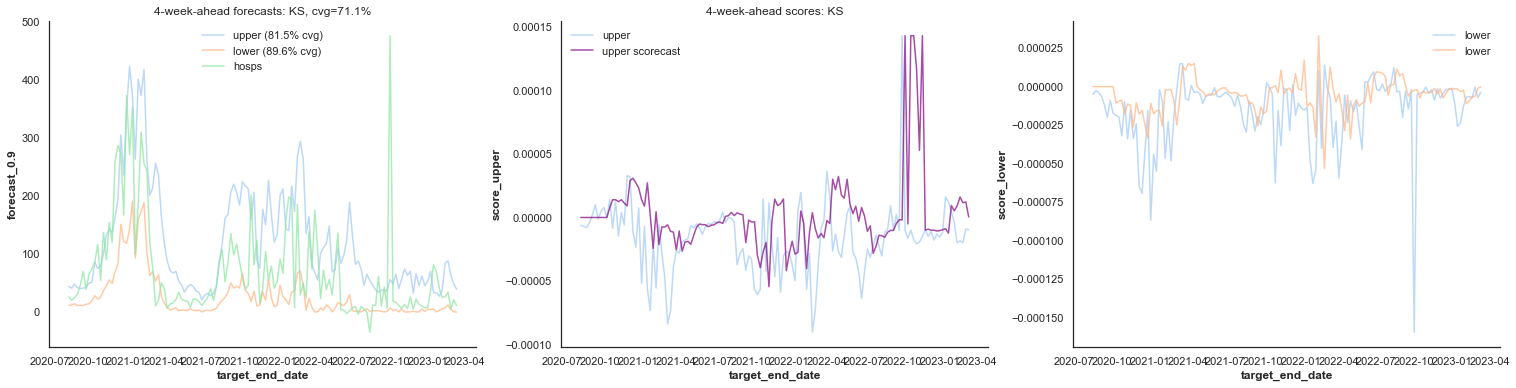

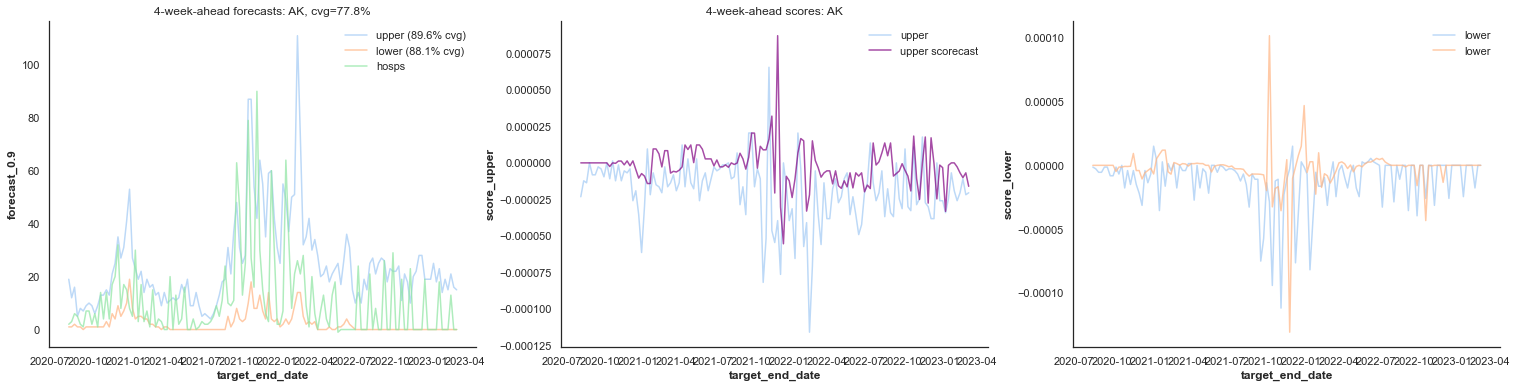

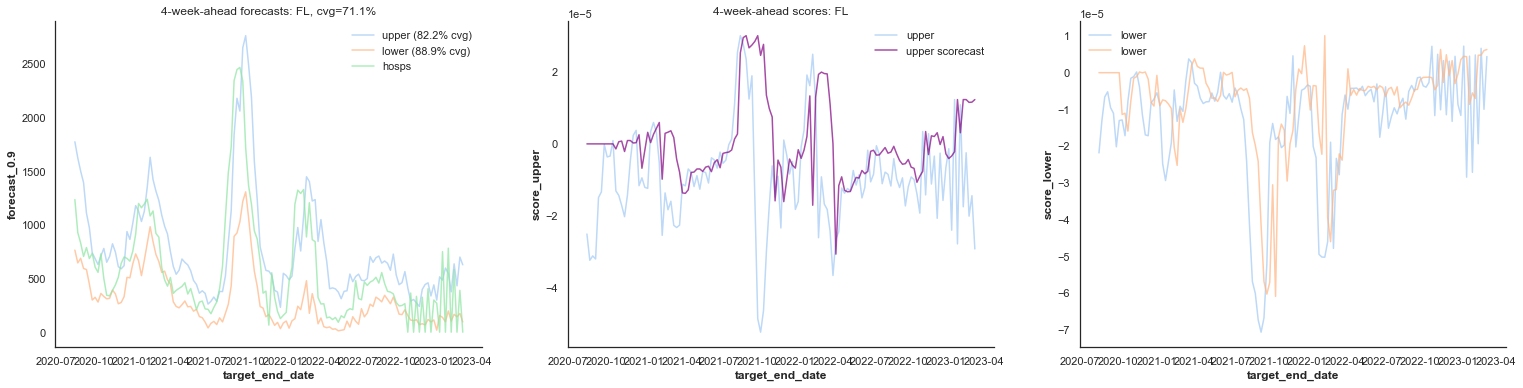

In [35]:
sns.set(palette='pastel', style='white')
states_to_plot = ['ca', 'ny', 'ga', 'tx', 'ks', 'ak', 'fl']
for geo in states_to_plot:
    data_geo = data[data.geo_value == geo]
    cvg_upper = (data_geo['score_upper'] <= 0).mean()
    cvg_lower = (data_geo['score_lower'] <= 0).mean()
    cvg_total = ((data_geo['score_lower'] <= 0) & (data_geo['score_upper'] <= 0)).mean()
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(26,6))
    sns.lineplot(data=data_geo, x='target_end_date', y='forecast_0.9', label=f"upper ({cvg_upper * 100 :.1f}% cvg)", errorbar=None, ax=axs[0], alpha=0.7)
    sns.lineplot(data=data_geo, x='target_end_date', y='forecast_0.1', label=f"lower ({cvg_lower * 100 :.1f}% cvg)", errorbar=None, ax=axs[0], alpha=0.7)
    sns.lineplot(data=data_geo, x='target_end_date', y='actual', label='hosps', errorbar=None, ax=axs[0], alpha=0.7)
    sns.lineplot(data=data_geo, x='target_end_date', y='score_upper', label='upper', errorbar=None, ax=axs[1], alpha=0.7)
    sns.lineplot(data=data_geo, x='target_end_date', y='scorecast_upper', label='upper scorecast', errorbar=None, ax=axs[1], alpha=0.7, color='purple')
    sns.lineplot(data=data_geo, x='target_end_date', y='score_lower', label='lower', errorbar=None, ax=axs[2], alpha=0.7)
    sns.lineplot(data=data_geo, x='target_end_date', y='scorecast_lower', label='lower', errorbar=None, ax=axs[2], alpha=0.7)
    sns.despine(top=True, right=True)
    axs[0].set_title(f"{weeks_ahead}-week-ahead forecasts: {geo.upper()}, cvg={cvg_total * 100 :.1f}%")
    axs[1].set_title(f"{weeks_ahead}-week-ahead scores: {geo.upper()}")

In [36]:
for st in states_to_plot:
    dataset = data[data['geo_value'] == st].drop(['geo_value'], axis=1)
    dataset['forecasts'] = [np.array([dataset['forecast_0.1'].iloc[j], dataset['forecast_0.9'].iloc[j]]) for j in range(len(dataset))]
    dataset['scorecasts'] = [np.array([dataset['scorecast_lower'].iloc[j]*dataset['population'].iloc[j], dataset['scorecast_upper'].iloc[j]*dataset['population'].iloc[j]]) for j in range(len(dataset))]
    dataset['scores'] = [np.array([dataset['score_lower'].iloc[j]*dataset['population'].iloc[j], dataset['score_upper'].iloc[j]*dataset['population'].iloc[j]]) for j in range(len(dataset))]
    dataset = dataset.drop(['forecast_0.1', 'forecast_0.5',
           'forecast_0.9', 'cases_forecast_0.1', 'cases_forecast_0.5',
           'cases_forecast_0.9', 'cases_actual', 'population', 'score_upper',
           'score_lower', 'cases_score_upper', 'cases_score_lower',
           'scorecast_upper', 'scorecast_lower'], axis=1).rename({'target_end_date' : 'timestamp', 'actual' : 'y'}, axis=1).melt(id_vars=['timestamp'], value_name='target')
    dataset.to_pickle(f"./{st}_proc_4wkdeaths.pkl")